# Data visualization

In [14]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
import sys
sys.path.append('../fpgp')
import plotting_tools
import utils
import matplotlib.pyplot as plt
import os


import numpy as np
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [15]:
exp_dir = '../data/1000_gen_time_exp'
benchmarks = sorted([os.path.join(exp_dir, d) for d in os.listdir(exp_dir)])
benchmarks

['../data/1000_gen_time_exp/f2']

In [16]:
logs, names = utils.get_results(benchmarks[0])

In [17]:
names

('SLcoev', 'exact', 'DScoev', 'MyPred2')

In [26]:
logs = [logs[i] for i in [0]]
names = [names[i] for i in [0]]

In [18]:
ts = []
errs = []
for l,n in zip(logs, names):
    ts.append(np.mean(utils.get_attributes_from_logs(l, 'time')))
    #print(n, utils.get_attributes_from_logs(l, 'time'))
    errs.append(np.std((utils.get_attributes_from_logs(l, 'time'))))

In [19]:
print(list(zip(names, ts, errs)))

[('SLcoev', 129.5512809944153, 18.28488113903937), ('exact', 120.58071337640285, 12.736491245619794), ('DScoev', 127.7261573791504, 14.506872170732981), ('MyPred2', 125.18659645318985, 14.2619237913214)]


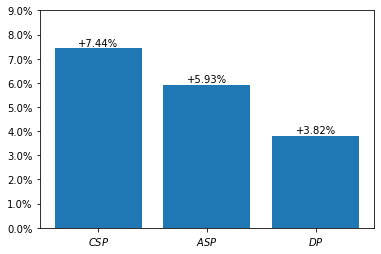

In [20]:
y = []
fig, ax = plt.subplots()
width = 0.8
for i in range(len(ts)):
    y.append((ts[i] - ts[1]) / ts[1] * 100)
rects = ax.bar([plotting_tools.names_to_latex(names)[i] for i in [0, 2, 3]], [y[i] for i in [0, 2, 3]], width=width)
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter())
for rect in rects:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2., height+0.01,
            '+' + str(round(height, 2)) + '%',
            ha='center', va='bottom')
plt.ylim(0, 9)
plt.savefig('../plots/time_spent.pdf')

In [28]:
print(np.mean(e[f > 1.5]) / 1e7, np.median(e[f > 1.5]) / 1e7, np.std(e[f > 1.5]) / 1e7)

1.9546062625 1.8853304 0.3942180994203746


In [ ]:
data = np.load(os.path.join(benchmarks[0], names[0], 'dataset.npz'))
trn_x, trn_y = data['trn'][:, :-1], data['trn'][:, -1]

In [155]:
heights = []
err = []
dist = []
x = (200, 100, 50, 1, 150)
x  = (25, 50, 150, 1, 10, 100, 200)
for ll, name in zip(logs, names):
    heights.append(np.mean(utils.get_attributes_from_logs(ll, 'time')))
    err.append(np.std(utils.get_attributes_from_logs(ll, 'time')))
    tmp = []
    for l in ll:
        evals = np.array(l['logbook'].select('evals'))
        tmp.append(np.mean(evals[1:-1] - evals[:-2]))
    dist.append(np.mean(tmp))

In [156]:
dist

[3800.0, 7000.0, 19800.0, 728.0, 1880.0, 13400.0, 26200.0]

In [137]:
heights

[2631.0, 1428.0, 505.0, 13737.0, 5319.0, 746.0, 381.0]

In [138]:
1e7 / np.array(dist)

array([ 2631.57894737,  1428.57142857,   505.05050505, 13736.26373626,
        5319.14893617,   746.26865672,   381.67938931])

In [162]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
#heights = [123 / (x + 1) + 15 for x in x]
xx = list(map(lambda x: [1e7/(128*x + 600)], x))
yy = list(map(lambda x: [x], heights))
regr.fit(xx, yy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [163]:
print(regr.coef_, regr.intercept_)
print(heights)
print(regr._residues)

[[0.03155541]] [43.99183086]
[137.2953006540026, 89.03095695972442, 43.14217844009399, 451.81374232769014, 277.97928524017334, 53.16565644741058, 36.46673145294189]
[6008.12741018]


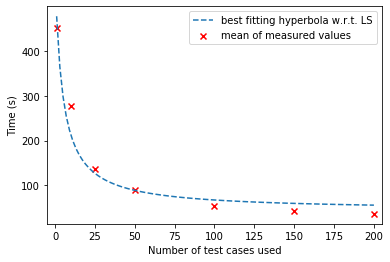

In [168]:
plt.scatter(x, heights, marker='x', color='red', label='mean of measured values')
plt.plot(np.linspace(1, 200, 100), regr.predict(1e7 / (np.linspace(1, 200, 100)*128 + 600)[None].reshape(-1, 1)), ls='--', label='best fitting hyperbola w.r.t. LS')
#plt.plot(np.linspace(1, 200, 100), 417 / np.linspace(1, 200, 100) + 33, ls='--', label='best fitting line w.r.t. LS')
plt.legend()
plt.xlabel('Number of test cases used')
plt.ylabel('Time (s)')
plt.xlim(-5, 205)
#plt.title('Time needed to reach 1000 generations')
plt.savefig('../plots/1e7_time.pdf')
plt.show()

In [ ]:
def run_time(samples, gens):
    return regr.predict([[samples]]) * (gens / 1000) 

In [ ]:
run_time(32, 2550)

In [ ]:
#plotting_tools.compare_performance(logs, 'evals', 'pred_size', method_names=names, ignore_tresh=np.inf, xlabel='Evaluations', ylabel='Test set fitness')
plotting_tools.compare_performance(logs, 'evals', 'test_set_f', method_names=names, ignore_tresh=np.inf, 
                                   xlabel='time', ylabel='Test set fitness', xscale='log', errorbars=False, stat_type='median')
#plt.savefig('gen_vs_time.pdf')

In [9]:
# select runs
runs = list(list(logs)[0])

In [10]:
log = runs[2]['logbook']

In [13]:
log.select('pred_size')[0]

31

## Histogram of test set fitnesses

In [14]:
sorted_logs = sorted(runs, key=lambda x: x['logbook'].select('test_set_f')[-1])
# select run you want to analyze
#log = sorted_logs[15]['logbook'] # best run

## Performance of the run

../fpgp/plotting_tools.py:124: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()


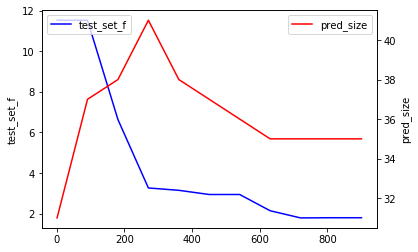

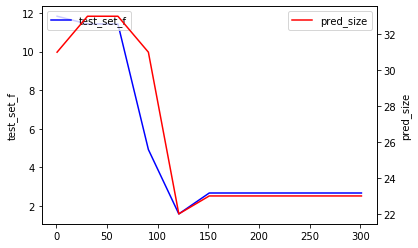

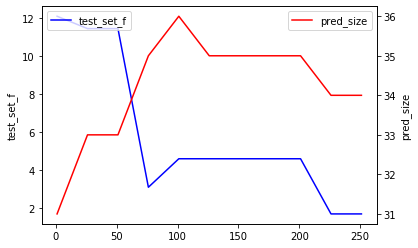

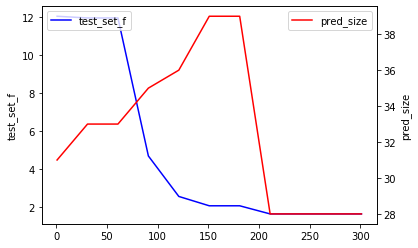

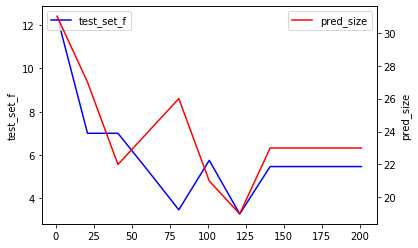

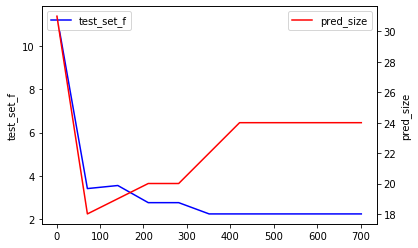

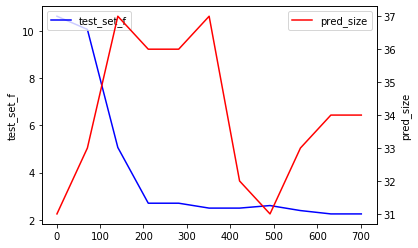

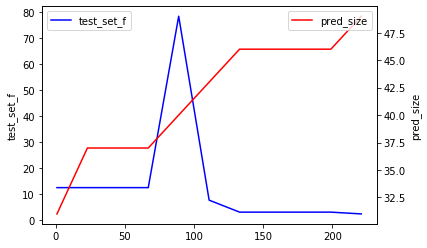

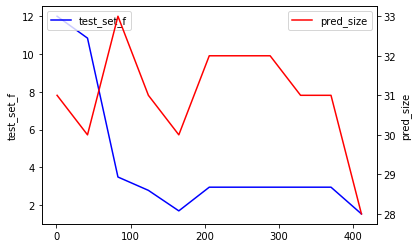

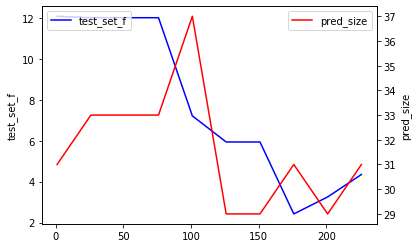

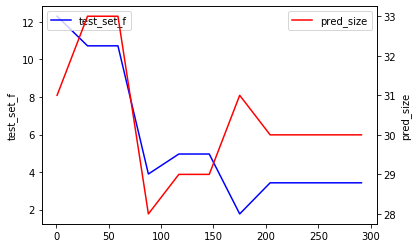

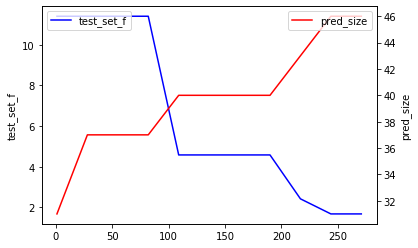

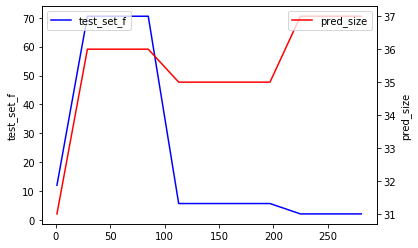

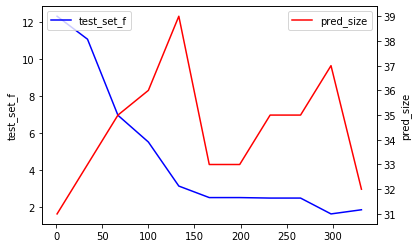

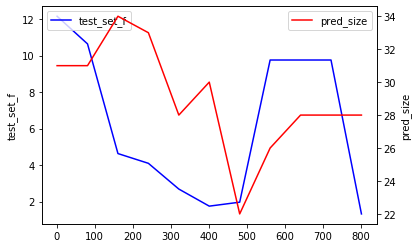

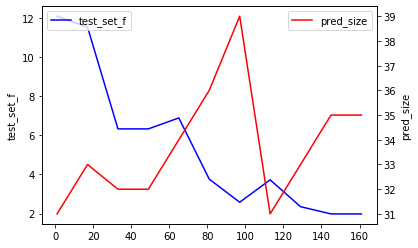

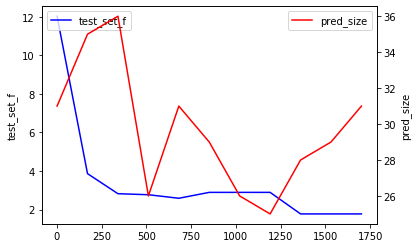

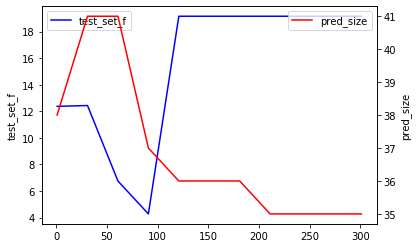

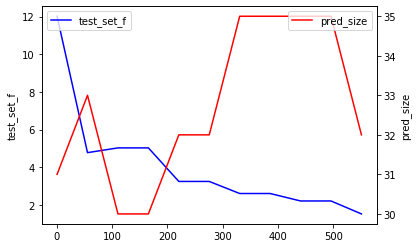

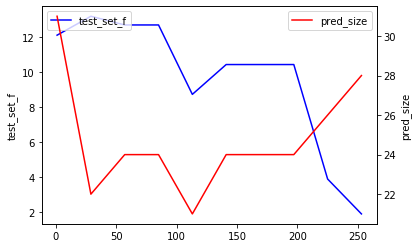

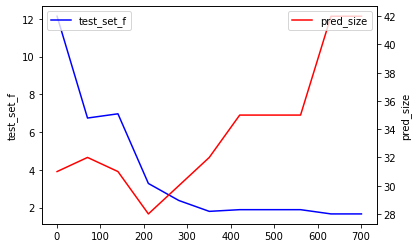

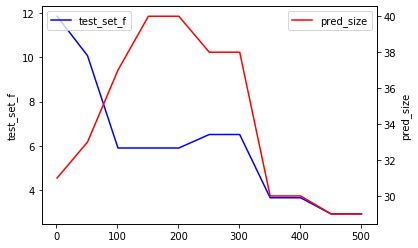

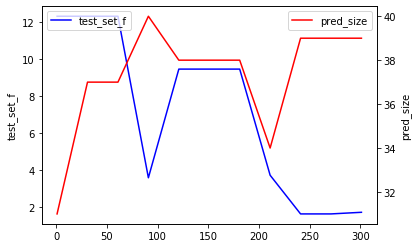

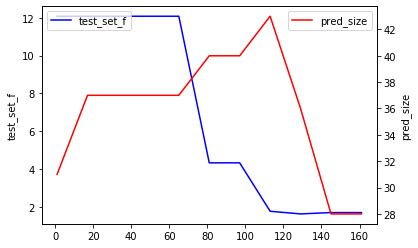

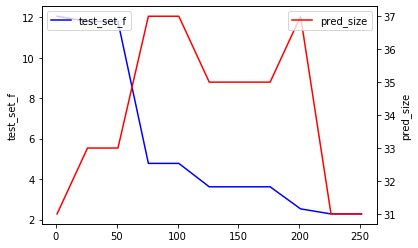

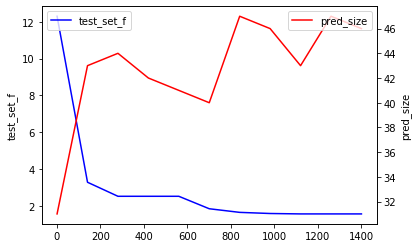

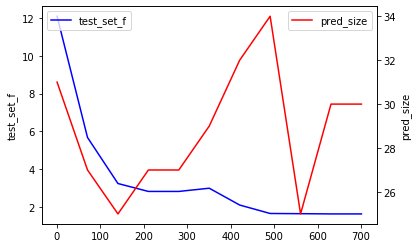

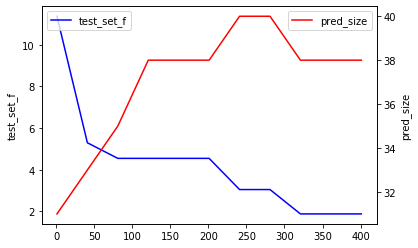

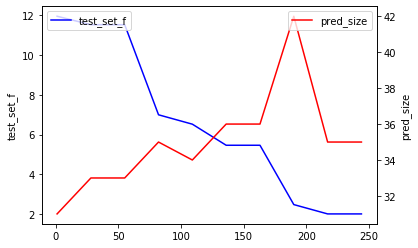

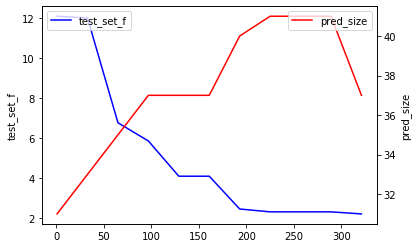

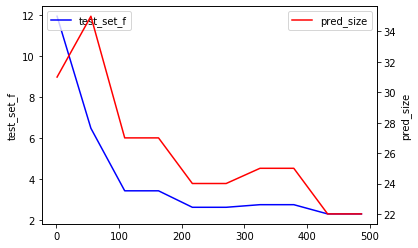

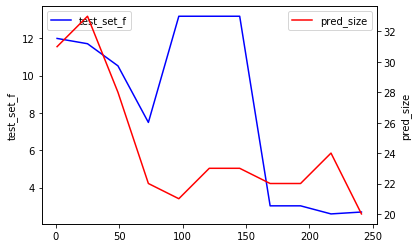

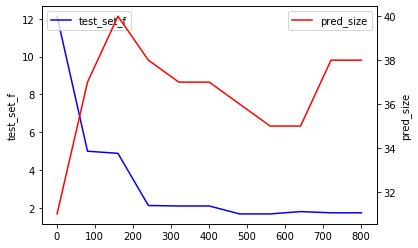

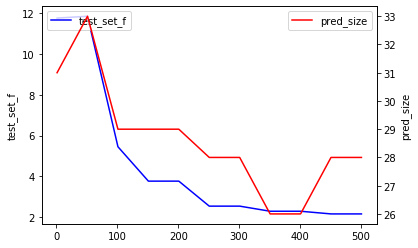

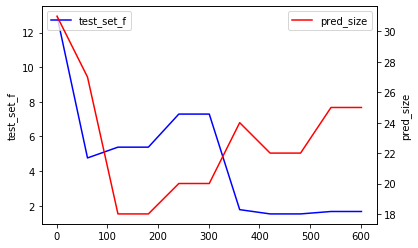

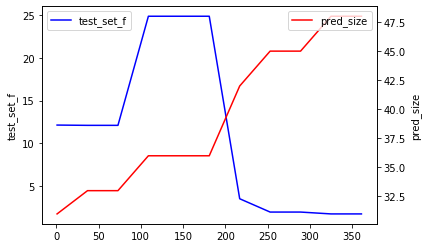

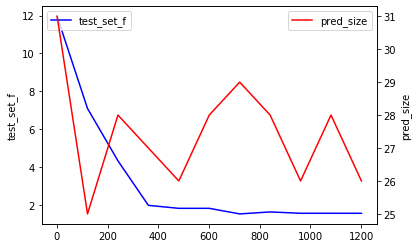

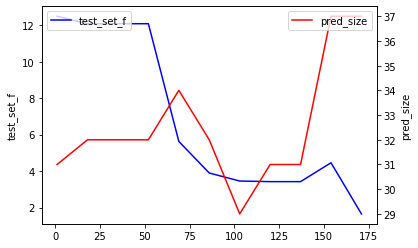

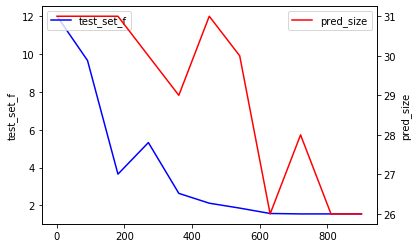

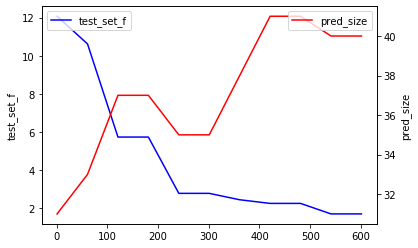

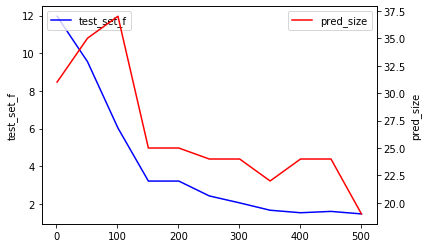

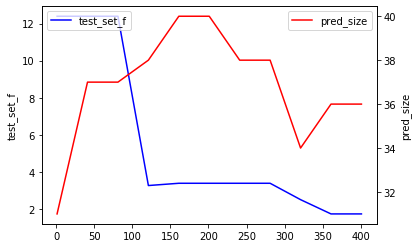

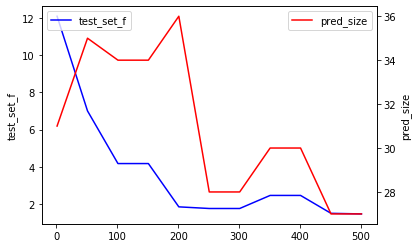

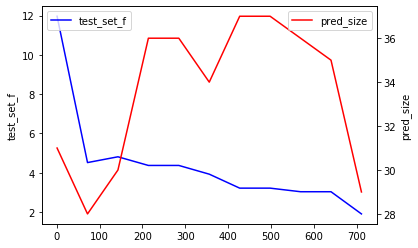

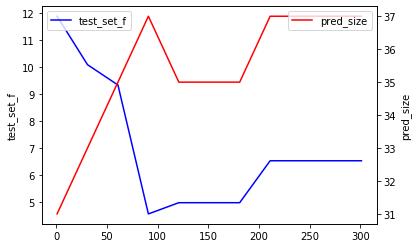

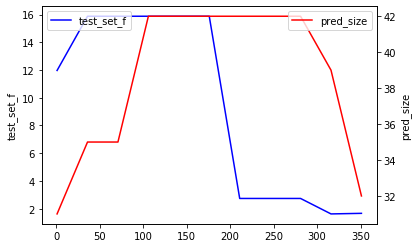

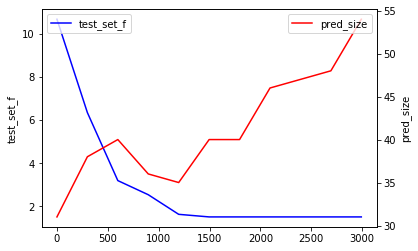

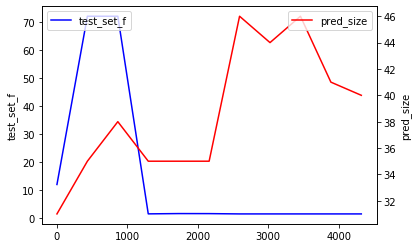

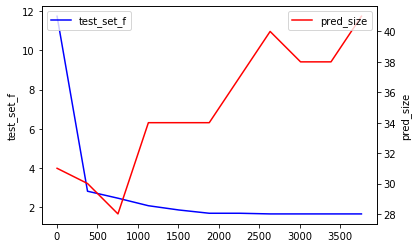

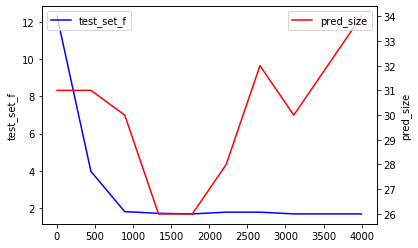

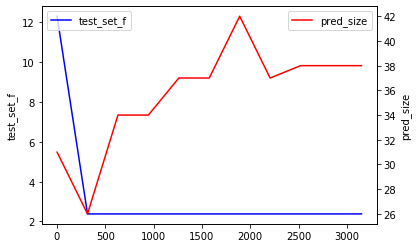

In [17]:
for l in sorted_logs:
    plotting_tools.two_stats_graph(l['logbook'], 'test_set_f', 'pred_size')
    #print(l['logbook'].select('test_set_f')[-1])
    #rint(l['logbook'].select('pred_size')[0])

## Found solution

In [ ]:
fig, ax = plt.subplots()
ax.plot(trn_x, log[-1]['best_sol_vals'], label='best solution found')
ax.plot(trn_x, trn_y, ls=' ', marker='o', ms='1', label='target function')
ax.legend()
plt.show()

## Histogram of used predictors

In [ ]:
plotting_tools.predictor_histogram(trn_x, trn_y, log)
plt.show()

## Animation of the progress of the run

In [ ]:
anim = plotting_tools.visualize_run(trn_x, trn_y, log, freq=20, step=1)
plt.show()